In [40]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['figure.dpi'] = 500
plt.rcParams['text.color'] = 'w'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['axes.edgecolor'] = 'w'
plt.rcParams['figure.facecolor'] = 'k'
plt.rcParams['axes.facecolor'] = 'k'
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from matplotlib.patches import FancyArrowPatch
import matplotlib.colors as colors
from astropy.visualization import SqrtStretch, LinearStretch, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import pandas as pd
import re
from astropy.io import fits
import os
from scipy.ndimage import map_coordinates
from scipy.stats import binned_statistic
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

from matplotlib.lines import Line2D
os.chdir("/Users/ainsleylewis/Documents/Astronomy/IllustrisTNG Lens Modelling")

In [41]:
# FITS File 
image = 'Deflection Shear Test/SHEAR_FIXED_1_lens.fits'

hdu_list = fits.open(image)
hdu_list.info()

# Extract kappa 
gamma1_sie = hdu_list[0].data[4]
gamma1_sie = np.array(gamma1_sie)

gamma2_sie = hdu_list[0].data[5]
gamma2_sie = np.array(gamma2_sie)

alphax_sie = hdu_list[0].data[0]
alphax_sie = np.array(alphax_sie)

alphay_sie = hdu_list[0].data[1]
alphay_sie = np.array(alphay_sie)

Filename: Deflection Shear Test/SHEAR_FIXED_1_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (1560, 1560, 8)   float32   


In [42]:
# FITS File 
image = 'Deflection Shear Test/SHEAR_FIXED_2_lens.fits'

hdu_list = fits.open(image)
hdu_list.info()

# Extract kappa 
gamma1_pert = hdu_list[0].data[4]
gamma1_pert = np.array(gamma1_pert)

gamma2_pert = hdu_list[0].data[5]
gamma2_pert = np.array(gamma2_pert)

alphax_pert = hdu_list[0].data[0]
alphax_pert = np.array(alphax_pert)

alphay_pert = hdu_list[0].data[1]
alphay_pert = np.array(alphay_pert)

Filename: Deflection Shear Test/SHEAR_FIXED_2_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (1560, 1560, 8)   float32   


In [43]:
# FITS File 
image = 'Deflection Shear Test/SHEAR_FIXED_3_lens.fits'

hdu_list = fits.open(image)
hdu_list.info()

# Extract kappa 
gamma1_tot = hdu_list[0].data[4]
gamma1_tot = np.array(gamma1_tot)

gamma2_tot = hdu_list[0].data[5]
gamma2_tot = np.array(gamma2_tot)

alphax_tot = hdu_list[0].data[0]
alphax_tot = np.array(alphax_tot)

alphay_tot = hdu_list[0].data[1]
alphay_tot = np.array(alphay_tot)

Filename: Deflection Shear Test/SHEAR_FIXED_3_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (1560, 1560, 8)   float32   


In [44]:
alpha_sie = np.sqrt(alphax_sie**2 + alphay_sie**2)
alpha_pert = np.sqrt(alphax_pert**2 + alphay_pert**2)
alpha_tot = np.sqrt(alphax_tot**2 + alphay_tot**2)

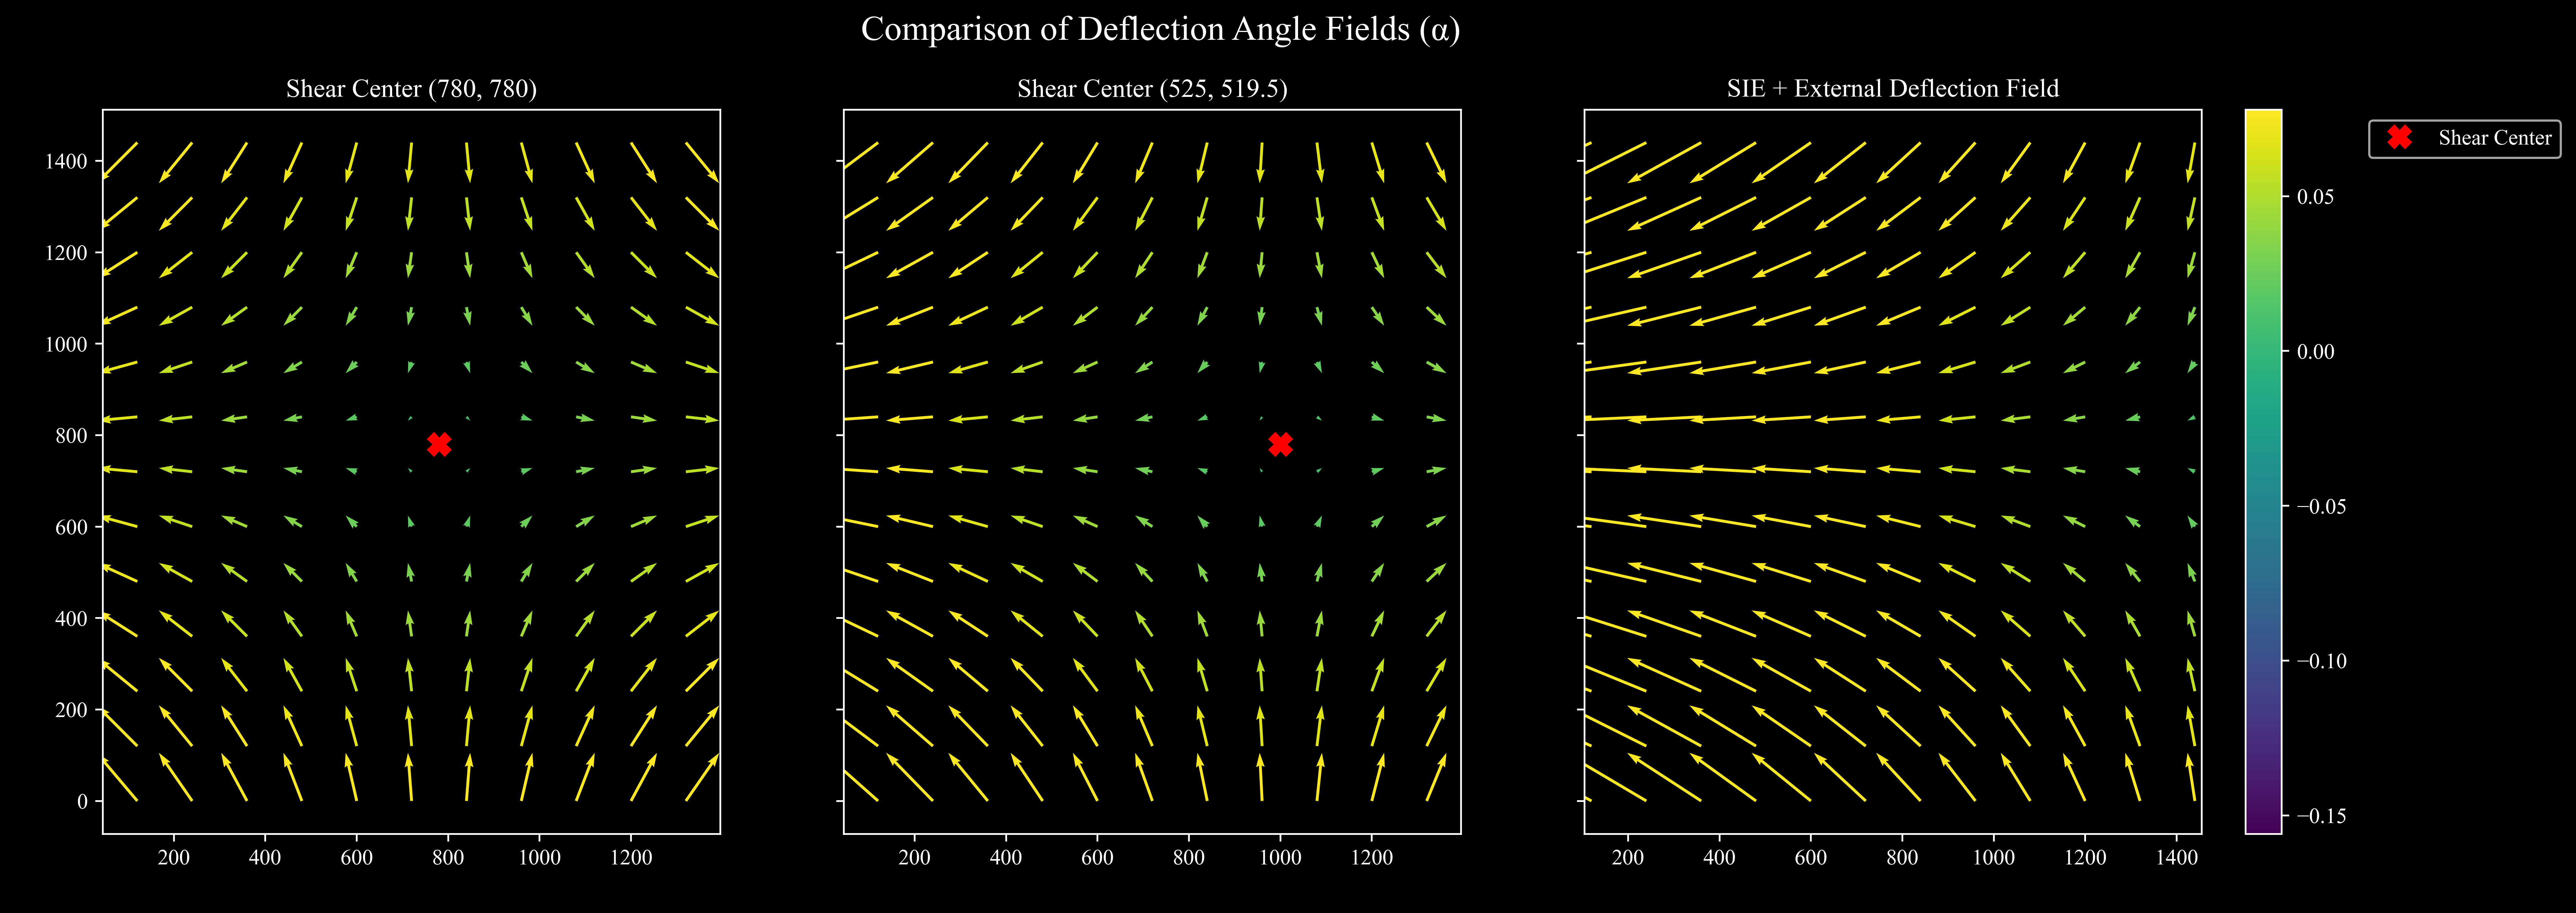

In [45]:
# 1. Combine all deflection angle magnitude data into a single array
all_alpha_data = np.concatenate([
    alphax_sie.flatten(),
    alphay_sie.flatten(),
    alphax_pert.flatten(),
    alphay_pert.flatten(),
    alphax_tot.flatten(),
    alphay_tot.flatten()
])

# 2. Define the color scale limits. Clip the max to the 98th percentile.
vmin = all_alpha_data.min()
vmax_clipped = np.percentile(all_alpha_data, 99)
vmax = all_alpha_data.max()  # Keep the original max for normalization

# 3. Create the shared Normalization object for colors
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# 4. Define other shared plotting parameters
cmap = 'viridis'  # Use a perceptually uniform colormap
# This scale defines the mapping from data units to arrow length.
arrow_scale = 1
step = 120
cbar_extend = 'max' # To indicate that colors for values > vmax are clipped

# === END OF IMPLEMENTATION ===

# --- Main Plotting ---
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Comparison of Deflection Angle Fields (α)', fontsize=16)

# Grid for quivers
ny, nx = alpha_sie.shape
x = np.arange(nx)
y = np.arange(ny)
X, Y = np.meshgrid(x, y)

# The '..._test' variables were calculated but not used in the original plot code
# alpha_sie_test = np.rad2deg(np.arctan2(alphay_sie, alphax_sie))
# alpha_sie_test = alpha_sie_test + np.deg2rad(90)

# --- Plot 1: SIE Deflection Field ---
U_sie =  alphax_sie
V_sie =  alphay_sie
q1 = axs[0].quiver(X[::step, ::step], Y[::step, ::step],
                   U_sie[::step, ::step], V_sie[::step, ::step],
                   alpha_sie[::step, ::step],
                   cmap=cmap, scale=arrow_scale, norm=norm) # <-- Apply shared norm & scale
axs[0].plot(780, 780, 'X', markersize=10, color = 'red', label = 'Shear Center')  # Mark the shear center
axs[0].set_title('Shear Center (780, 780)')
axs[0].axis('equal')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')

# --- Plot 2: Perturbation Deflection Field ---
U_pert = alphax_pert  # x-component
V_pert = alphay_pert  # y-component
q2 = axs[1].quiver(X[::step, ::step], Y[::step, ::step],
                   U_pert[::step, ::step], V_pert[::step, ::step],
                   alpha_pert[::step, ::step],
                   cmap=cmap, scale=arrow_scale, norm=norm) # <-- Apply shared norm & scale
axs[1].plot(1000, 780, 'X', markersize=10, color = 'red')  # Mark the shear center
axs[1].set_title('Shear Center (525, 519.5)')
axs[1].axis('equal')
axs[1].set_xlabel('X')

# --- Plot 3: Total Deflection Field ---
U_tot =  alphax_tot  # x-component
V_tot =  alphay_tot
q3 = axs[2].quiver(X[::step, ::step], Y[::step, ::step],
                   U_tot[::step, ::step], V_tot[::step, ::step],
                   alpha_tot[::step, ::step],
                   cmap=cmap, scale=arrow_scale, norm=norm) # <-- Apply shared norm & scale
axs[2].plot(1560, 780, 'X', markersize=10, color = 'red')  # Mark the shear center
axs[2].set_title('SIE + External Deflection Field')
axs[2].axis('equal')
axs[2].set_xlabel('X')

# Add a single legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, 0.88))

# --- Add a common colorbar for all plots ---
cbar = fig.colorbar(q3, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('Deflection Angle Magnitude (α)')

plt.show()

In [ ]:
# FITS File 
image = 'Deflection Shear Test/SHEAR_FIXED_1_lens.fits'

hdu_list = fits.open(image)
hdu_list.info()

# Extract kappa 
gamma1_sie = hdu_list[0].data[4]
gamma1_sie = np.array(gamma1_sie)

gamma2_sie = hdu_list[0].data[5]
gamma2_sie = np.array(gamma2_sie)

alphax_sie = hdu_list[0].data[0]
alphax_sie = np.array(alphax_sie)

alphay_sie = hdu_list[0].data[1]
alphay_sie = np.array(alphay_sie)

In [ ]:
# FITS File 
image = 'Deflection Shear Test/SHEAR_FIXED_2_lens.fits'

hdu_list = fits.open(image)
hdu_list.info()

# Extract kappa 
gamma1_pert = hdu_list[0].data[4]
gamma1_pert = np.array(gamma1_pert)

gamma2_pert = hdu_list[0].data[5]
gamma2_pert = np.array(gamma2_pert)

alphax_pert = hdu_list[0].data[0]
alphax_pert = np.array(alphax_pert)

alphay_pert = hdu_list[0].data[1]
alphay_pert = np.array(alphay_pert)

In [ ]:
# FITS File 
image = 'Deflection Shear Test/SHEAR_FIXED_3_lens.fits'

hdu_list = fits.open(image)
hdu_list.info()

# Extract kappa 
gamma1_tot = hdu_list[0].data[4]
gamma1_tot = np.array(gamma1_tot)

gamma2_tot = hdu_list[0].data[5]
gamma2_tot = np.array(gamma2_tot)

alphax_tot = hdu_list[0].data[0]
alphax_tot = np.array(alphax_tot)

alphay_tot = hdu_list[0].data[1]
alphay_tot = np.array(alphay_tot)

In [ ]:
alpha_sie = np.sqrt(alphax_sie**2 + alphay_sie**2)
alpha_pert = np.sqrt(alphax_pert**2 + alphay_pert**2)
alpha_tot = np.sqrt(alphax_tot**2 + alphay_tot**2)